# **Lab 6 Transfer Learning & Hyperparameter Tuning**

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import cv2
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

seed = 4912
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

c:\Users\Acer\anaconda3\envs\ML_Environment\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


ModuleNotFoundError: No module named 'tqdm'

## Data Preparation
Complete the class `CustomImageDataset()` that `__getitem__` return ***noisy blury*** image and ***ground truth*** image.
Please ensure that the final image is in RGBscale and has a size of 128x128.

In [2]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, gauss_noise=False, gauss_blur=False, resize=128, p=0.5):
        self.p = p  # Probability for applying noise/blur
        self.resize = resize  # Final image size
        self.gauss_noise = gauss_noise  # Whether to apply Gaussian noise
        self.gauss_blur = gauss_blur  # Whether to apply Gaussian blur
        self.image_paths = image_paths  # List of image paths

        # Transformation to resize the image to the required size
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((resize, resize)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image from the file path
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)  # Read image using OpenCV (BGR format)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Apply transformations to get the ground truth image (resize and convert to tensor)
        gt_image = self.transform(image)

        # Add Gaussian noise to the image with probability p
        if self.gauss_noise and random.random() < self.p:
            noise_mean = random.uniform(-50, 50) / 255.0  # Random noise mean in range [-50, 50] scaled
            image = random_noise(image, mode='gaussian', mean=noise_mean, var=0.01)  # Add Gaussian noise
            image = np.array(255 * image, dtype='uint8')

        # Apply Gaussian blur to the image with probability p
        if self.gauss_blur and random.random() < self.p:
            blur_kernel_size = random.choice(range(3, 12, 2))  # Random kernel size in the range [3, 11]
            image = cv2.GaussianBlur(image, (blur_kernel_size, blur_kernel_size), 5)  # Apply Gaussian blur

        # Resize the noisy image and convert to tensor
        noisy_image = self.transform(image)

        return noisy_image, gt_image
### END CODE HERE ###

In [3]:
### START CODE HERE ###
def imshow_grid(images, ncols=4):
    fig, axes = plt.subplots(nrows=len(images) // ncols, ncols=ncols, figsize=(12, 12))
    axes = axes.flatten()
    
    for img, ax in zip(images, axes):
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # Convert the image to the right format
        ax.axis('off')

    plt.tight_layout()
    plt.show()
### END CODE HERE ###

In [4]:
### START CODE HERE ###
relative_dir = "img_align_celeba"
data_dir = os.path.abspath(relative_dir)
# print(data_dir)
image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith(".jpg")]

dataset = CustomImageDataset(image_paths, gauss_noise=True, gauss_blur=5, resize=128, p=0.5)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
### END CODE HERE ###

Noisy blury images


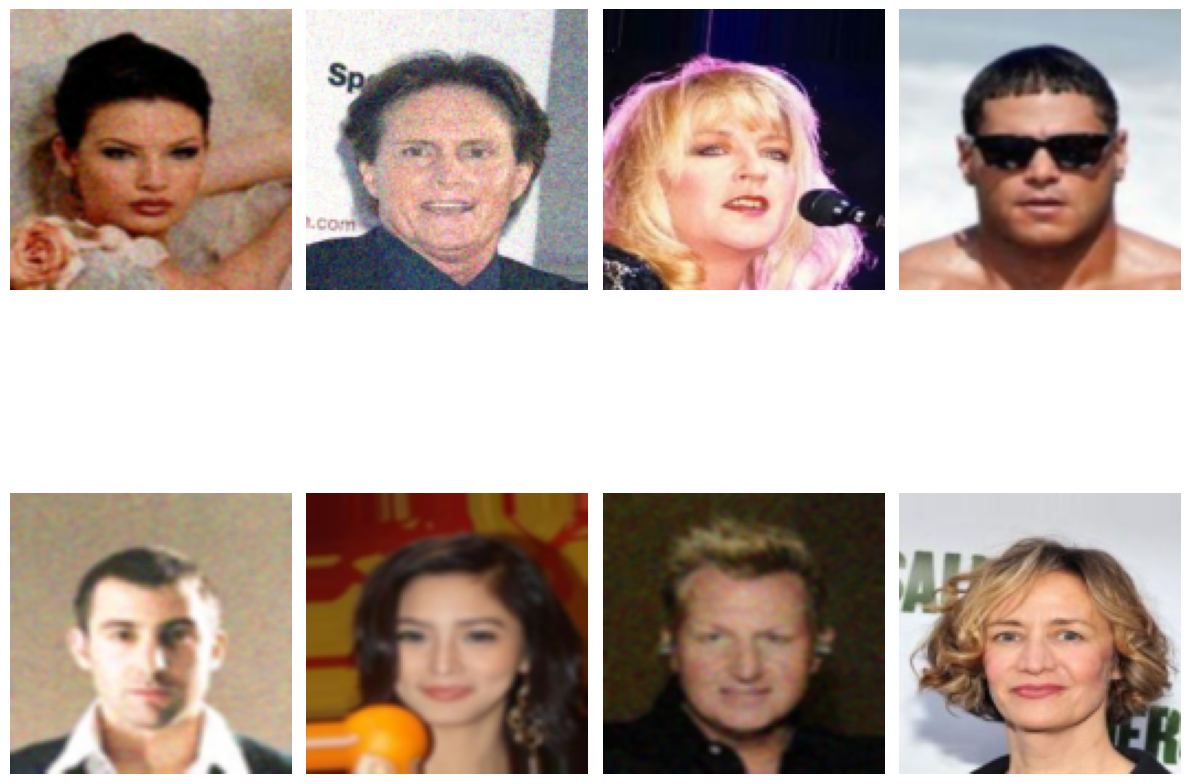

Ground Truth images


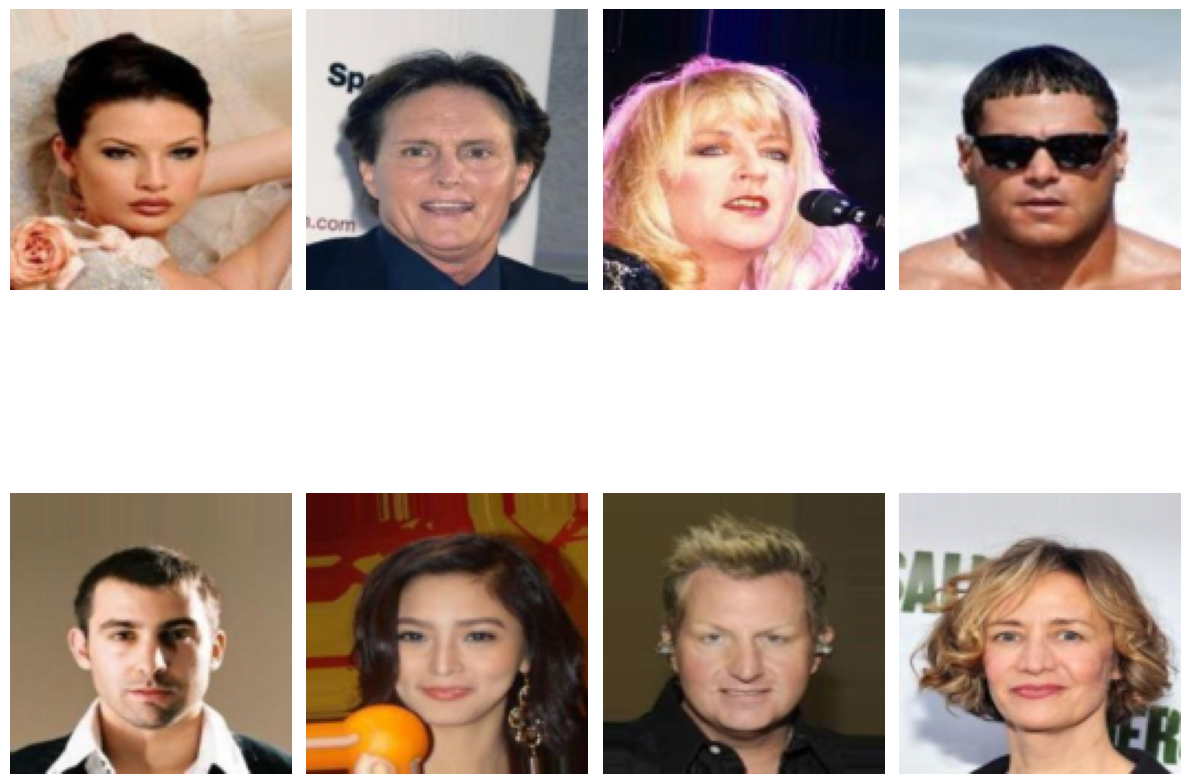

In [5]:
### START CODE HERE ###
batch, gt_img = next(iter(dataloader)) 

# Display a batch of noisy images and ground truth images
print("Noisy blury images")
imshow_grid(batch)
print("Ground Truth images")
imshow_grid(gt_img)
### END CODE HERE ###

## Create Autoencoder model
You can design your own Autoencoder model with a customizable number of downsampling and upsampling blocks by passing a list of channel numbers for each layer based on the provided code below. However, please maintain the concept of 'Autoencoder'.

In [6]:
### START CODE HERE ###
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, channels=[64, 128, 256], input_channels=3, output_channels=3):
        super(Autoencoder, self).__init__()
        
        # Encoder: Downsampling layers
        self.encoder = nn.ModuleList()
        in_channels = input_channels
        for out_channels in channels:
            self.encoder.append(DownSamplingBlock(in_channels, out_channels))
            in_channels = out_channels
        
        # Decoder: Upsampling layers (reverse of the encoder)
        self.decoder = nn.ModuleList()
        for out_channels in reversed(channels[:-1]):
            self.decoder.append(UpSamplingBlock(in_channels, out_channels))
            in_channels = out_channels
        # Final layer to map back to the original number of channels
        self.decoder.append(UpSamplingBlock(in_channels, output_channels))

    def forward(self, x):
        # Encoding
        for layer in self.encoder:
            x = layer(x)
        
        # Decoding
        for layer in self.decoder:
            x = layer(x)
        
        return x
### END CODE HERE ###

## Train Autoencoder
Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the ***training loss, test loss,test PSNR, test SSIM***. Additionally, it should save the model at the last epoch.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The log should resemble this, but not be identical

```
🤖Training on cuda
🚀Training Epoch [1/1]: 100%|██████████| 1313/1313 [01:45<00:00, 12.41batch/s, loss=0.0102] 
📄Testing: 100%|██████████| 563/563 [01:10<00:00,  7.95batch/s, loss=0.0106, psnr=16.7, ssim=0.348] 
Summary :
	Train	avg_loss: 0.017262999383663165
	Test	avg_loss: 0.010476540363861867 
                PSNR : 16.839487147468034 
                SSIM : 0.36090552368883694
...
```

</details>

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [PSNR & SSIM](https://ieeexplore.ieee.org/document/5596999)

In [7]:
### START CODE HERE ###
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    print("🤖Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, gt in train_bar:
            images, gt = images.to(device), gt.to(device)
            
            # Forward pass
            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, gt)
            loss.backward()
            opt.step()
            
            total_train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())
        
        avg_train_loss = total_train_loss / len(train_loader)
        
        # Testing phase
        model.eval()
        total_test_loss = 0
        total_psnr = 0
        total_ssim = 0
        
        test_bar = tqdm(test_loader, desc='📄Testing', unit='batch')
        with torch.no_grad():
            for images, gt in test_bar:
                images, gt = images.to(device), gt.to(device)
                
                outputs = model(images)
                loss = loss_fn(outputs, gt)
                total_test_loss += loss.item()
                
                # Convert outputs and gt to numpy arrays for PSNR and SSIM calculations
                outputs_np = outputs.permute(0, 2, 3, 1).cpu().numpy()
                gt_np = gt.permute(0, 2, 3, 1).cpu().numpy()
                
                # Calculate PSNR and SSIM for the batch
                batch_psnr = np.mean([psnr(gt_np[i], outputs_np[i]) for i in range(gt_np.shape[0])])
                
                # Set win_size to 3 and use channel_axis for SSIM, specifying data_range
                batch_ssim = np.mean([ssim(gt_np[i], outputs_np[i], win_size=3, channel_axis=-1, data_range=1.0) for i in range(gt_np.shape[0])])
                
                total_psnr += batch_psnr
                total_ssim += batch_ssim
                
                test_bar.set_postfix(loss=loss.item(), psnr=batch_psnr, ssim=batch_ssim)
        
        avg_test_loss = total_test_loss / len(test_loader)
        avg_psnr = total_psnr / len(test_loader)
        avg_ssim = total_ssim / len(test_loader)
        
        # Log summary for the epoch
        print(f'Summary for Epoch {epoch+1}/{epochs}:')
        print(f'    Train    avg_loss: {avg_train_loss}')
        print(f'    Test     avg_loss: {avg_test_loss}')
        print(f'                PSNR : {avg_psnr}')
        print(f'                SSIM : {avg_ssim}')
        
        # Save model at the last epoch
        if epoch == epochs - 1 and checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved at {checkpoint_path}')

### END CODE HERE ###


Let's train your model with 2 epochs to verify that your train() function works properly. After that, we'll move on to the Hyperparameter Grid Search in the next part.

In [8]:
### START CODE HERE ###
# CODE FOR PRODUCTION USE
# -------------------------------------------------------------------------------------------------
## START CODE HERE ###
files = os.listdir(data_dir)
files = [os.path.join(data_dir, file) for file in files]

# Split the dataset into training and testing sets
train_files, test_files = train_test_split(files, test_size=0.3, shuffle=True, random_state=2024)

train_dataset = CustomImageDataset(train_files, gauss_noise=True, gauss_blur=True)
test_dataset = CustomImageDataset(test_files, gauss_noise=True, gauss_blur=True)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# -------------------------------------------------------------------------------------------------
### END CODE HERE ###

In [63]:
# #CODE FOR TESTING
# # -------------------------------------------------------------------------------------------------
# # List all image files in the directory
# files = os.listdir(data_dir)
# files = [os.path.join(data_dir, file) for file in files]

# # Define the size of the subsets
# train_size = 15  # Number of images for training
# test_size = 20  # Number of images for testing

# # Sample a small subset of files
# sampled_files = np.random.choice(files, size=train_size + test_size, replace=False)

# # Split the sampled files into training and testing sets
# train_files, test_files = train_test_split(sampled_files, test_size=test_size, random_state=42)


# # Create dataset objects with the option for augmentations like Gaussian noise and blur
# train_dataset = CustomImageDataset(train_files, gauss_noise=True, gauss_blur=5, resize=128, p=0.5)
# test_dataset = CustomImageDataset(test_files, gauss_noise=False, gauss_blur=None, resize=128, p=0.5)

# # Create DataLoaders for both training and testing datasets
# trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Print the sizes of the datasets
# print(f"Number of training files: {len(train_files)}")
# print(f"Number of test files: {len(test_files)}")
# # -------------------------------------------------------------------------------------------------

Number of training files: 15
Number of test files: 20


In [9]:
### START CODE HERE ###
# # Initialize model, optimizer, and loss function
model = Autoencoder()
# opt = optim.Adam(model.parameters(), lr=0.001)
# loss_fn = nn.MSELoss()

# # Train the model
# train(model, opt, loss_fn, trainloader, testloader, epochs=1, checkpoint_path='autoencoder.pth', device='cuda' if torch.cuda.is_available() else 'cpu')

### END CODE HERE ###

---

## **Hyperparameter Grid Search with Raytune**

*If you have access to APEX, I would recommend converting this part into a Python file and submitting the job to run on APEX using SBATCH. This process may take a considerable amount of time.*

You can import additional Ray Tune tools as you want, such as schedulers, search algorithms, etc. Further information on the usage of Ray Tune can be found [here](https://docs.ray.io/en/latest/tune/index.html).

In [65]:
# !pip install ray

Complete the `train_raytune()` function below, following the [quick start guide](https://docs.ray.io/en/latest/tune/index.html). This function will be passed to the `tune.Tuner`.

In [10]:
import ray
from ray import tune
from ray.air import session
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from ray.air.config import RunConfig
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

ray.shutdown()

In [11]:
def train_raytune(config):
    # Define data loaders (use your dataset)
    transform = transforms.Compose([
        transforms.Resize(128),  # Resize to 128x128
        transforms.ToTensor()
    ])

    trainloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    # Instantiate the model
    model = Autoencoder(channels=config['architecture'], input_channels=3, output_channels=3)
    model = model.to(config['device'])
    
    # Define optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)

    # Loss function
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(config['num_epochs']):
        model.train()
        total_train_loss = 0
        for images, _ in trainloader:  # Assuming ground truth is the same input for autoencoder
            images = images.to(config['device'])

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(trainloader)

        # Validation loop
        model.eval()
        total_val_loss = 0
        total_psnr = 0
        total_ssim = 0
        with torch.no_grad():
            for images, _ in testloader:
                images = images.to(config['device'])
                outputs = model(images)
                loss = criterion(outputs, images)
                total_val_loss += loss.item()

                # Convert images to numpy for PSNR and SSIM calculation
                images_np = images.cpu().numpy()
                outputs_np = outputs.cpu().numpy()

                # Calculate PSNR and SSIM for each image in the batch
                batch_psnr = 0
                batch_ssim = 0
                for i in range(images_np.shape[0]):
                    img_gt = images_np[i].transpose(1, 2, 0)  # HWC format for PSNR and SSIM
                    img_pred = outputs_np[i].transpose(1, 2, 0)
                    
                    # PSNR and SSIM calculation with data_range specified
                    batch_psnr += psnr(img_gt, img_pred, data_range=img_gt.max() - img_gt.min())
                    batch_ssim += ssim(img_gt, img_pred, data_range=1.0, win_size=3, channel_axis=-1)

                total_psnr += batch_psnr / images_np.shape[0]
                total_ssim += batch_ssim / images_np.shape[0]

        avg_val_loss = total_val_loss / len(testloader)
        avg_val_psnr = total_psnr / len(testloader)
        avg_val_ssim = total_ssim / len(testloader)

        # Report metrics to Ray Tune
        session.report({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_psnr": avg_val_psnr,
            "val_ssim": avg_val_ssim
        })


Initialize Ray, define the search space, and resources.

Resource : 
- [A Guide To Parallelism and Resources for Ray Tune](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html#:~:text=A%20Guide%20To%20Parallelism%20and%20Resources%20for%20Ray%20Tune) 
- [Working with Tune Search Spaces](https://docs.ray.io/en/latest/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial:~:text=Working%20with%20Tune%20Search%20Spaces)
- [How to configure logging in Tune?](https://docs.ray.io/en/latest/tune/tutorials/tune-output.html) 
- [Tune Trial Schedulers (`tune.schedulers`)](https://docs.ray.io/en/latest/tune/api/schedulers.html#tune-scheduler-pbt:~:text=Tune%20Trial...-,Tune%20Trial%20Schedulers%20(tune.schedulers),-%23)

**Search Space:**
- `architecture`:<br>
    Feature map dimensions for convolutional layers<br>
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with more depth, starting from 64 and ending at 512.
- `learning rates (lr)`:
    - [1e-3, 8e-4, 1e-4, 1e-2]: Test a wide range of learning rates to evaluate model performance, from 1e-3 (typical) to a more aggressive 1e-2 or conservative 1e-4.
- `batch size`:
    - [16, 32]: Explore smaller batch sizes to evaluate their impact on gradient estimation and memory usage.
- `number of epochs`:
    - `[10, 50, 100]`: Allow short and long training sessions, from quick evaluations (10 epochs) to more extensive training (100 epochs).
- `optimizers (opts)`:
    - `["Adam", "SGD"]`: Compare two popular optimization algorithms: Adam for adaptive learning rates and SGD for momentum-based updates.

In [68]:
# #CODE FOR TESTING
# # -------------------------------------------------------------------------------------------------
# ### START CODE HERE ###
# relative_dir_result = "ray_results/grid_search/"
# if not os.path.exists(relative_dir_result):
#     os.makedirs(relative_dir_result)
# absolute_dir_result = os.path.abspath(relative_dir_result)

# # Define a simple trial directory name creator to shorten paths
# def trial_dirname_creator(trial):
#     return f"{trial.trainable_name}_{trial.trial_id}"

# # Initialize Ray
# ray.init(num_gpus=1)

# # Fix the device key and ensure it's included in the config
# config = {
#     'architecture': tune.grid_search([
#         [32, 64, 128],
#     ]),
#     'lr': tune.grid_search([1e-3]),
#     'batch_size': tune.grid_search([16]),
#     'num_epochs': tune.grid_search([1]),
#     'optimizer': tune.grid_search(['Adam']),
#     'input_channels': 3,
#     'output_channels': 3,
#     'device': 'cuda' if torch.cuda.is_available() else 'cpu'  # Make sure device is included
# }

# # Define Tuner with custom trial_dirname_creator to shorten directory paths
# tuner = tune.Tuner(
#     trainable=train_raytune,
#     param_space=config,
#     tune_config=tune.TuneConfig(
#         metric="val_psnr",
#         mode="max",
#         num_samples=1,  # Reduce to 1 sample for fast iteration
#         trial_dirname_creator=trial_dirname_creator
#     ),
#     run_config=RunConfig(
#         storage_path=absolute_dir_result
#     )
# )

# # Run the Tuner
# result = tuner.fit()
# ### END CODE HERE ###

2024-09-19 00:18:50,967	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/Acer/Desktop/Image Processing/Lab/Lab6_Hyperparameter-Tuning/ray_results/grid_search/train_raytune_2024-09-19_00-18-20' in 0.0200s.
2024-09-19 00:18:50,985	INFO tune.py:1041 -- Total run time: 30.45 seconds (30.32 seconds for the tuning loop).


In [69]:
# CODE FOR PRODUCTION USE
# -------------------------------------------------------------------------------------------------
## START CODE HERE ###
relative_dir_result = "ray_results/grid_search/"
if not os.path.exists(relative_dir_result):
    os.makedirs(relative_dir_result)
absolute_dir_result = os.path.abspath(relative_dir_result)

# Define a simple trial directory name creator to shorten paths
def trial_dirname_creator(trial):
    return f"{trial.trainable_name}_{trial.trial_id}"

# Initialize Ray
ray.init(num_gpus=1)

# Fix the device key and ensure it's included in the config
config = {
    'architecture': tune.grid_search([
        [32, 64, 128],
        [64, 128, 256],
        [64, 128, 256, 512]
    ]),
    'lr': tune.grid_search([1e-3, 8e-4, 1e-4, 1e-2]),
    'batch_size': tune.grid_search([16, 32]),
    'num_epochs': tune.grid_search([10, 50, 100]),
    'optimizer': tune.grid_search(['Adam', 'SGD']),
    'input_channels': 3,
    'output_channels': 3,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'  # Make sure device is included
}

# Define Tuner with custom trial_dirname_creator to shorten directory paths
tuner = tune.Tuner(
    trainable=train_raytune,
    param_space=config,
    tune_config=tune.TuneConfig(
        metric="val_psnr",
        mode="max",
        num_samples=1,  # Reduce to 1 sample for fast iteration
        trial_dirname_creator=trial_dirname_creator
    ),
    run_config=RunConfig(
        storage_path=absolute_dir_result
    )
)

# Run the Tuner
result = tuner.fit()
## END CODE HERE ###

Restore the result from path of ray resule directory

In [70]:
### START CODE HERE ###
import os
import glob

# Get the most recently modified directory
latest_path = max(glob.glob(os.path.join(absolute_dir_result, '*/')), key=os.path.getmtime)

# Get the directory name (last part of the path)
latest_directory_name = os.path.basename(os.path.normpath(latest_path))

# Print the latest directory name
print(f"The latest directory in {relative_dir_result}: {latest_directory_name}")

restored_tuner = tune.Tuner.restore(latest_path, trainable='train_raytune')
### END CODE HERE ###

The latest directory in ray_results/grid_search/: train_raytune_2024-09-19_00-18-20


Get the report from Grid Search to CSV file.

In [71]:
print("🎉[INFO] Training is done!")
print("Best config is:", result.get_best_result().config)
print("Best result is:", result.get_best_result())
df = result.get_dataframe()

# Define the folder and CSV name
csv_name = "best_grid_search.csv"

# Create the full path for the CSV file
csv_path = os.path.join(relative_dir_result, csv_name)

# Ensure the folder exists
os.makedirs(relative_dir_result, exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(csv_path, index=False)

print(f"Results saved to: {csv_path}")

🎉[INFO] Training is done!
Best config is: {'architecture': [32, 64, 128], 'lr': 0.001, 'batch_size': 16, 'num_epochs': 1, 'optimizer': 'Adam', 'input_channels': 3, 'output_channels': 3, 'device': 'cpu'}
Best result is: Result(
  metrics={'train_loss': 0.3202429711818695, 'val_loss': 0.3354744464159012, 'val_psnr': 5.115524699000558, 'val_ssim': 0.04136736280634068},
  path='c:/Users/Acer/Desktop/Image Processing/Lab/Lab6_Hyperparameter-Tuning/ray_results/grid_search/train_raytune_2024-09-19_00-18-20/train_raytune_00ab8_00000',
  filesystem='local',
  checkpoint=None
)
Results saved to: ray_results/grid_search/best_grid_search.csv


---

Train the Autoencoder models using the best hyperparameter set obtained from the grid search.

In [72]:
### START CODE HERE ###
# Train the Autoencoder with the best hyperparameters
best_config = result.get_best_result().config
model = Autoencoder(channels=best_config['architecture'], input_channels=3, output_channels=3)
opt = optim.Adam(model.parameters(), lr=best_config['lr']) if best_config['optimizer'] == 'Adam' else optim.SGD(model.parameters(), lr=best_config['lr'], momentum=0.9)
loss_fn = nn.MSELoss()

# Define the filename
checkpoint_filename = "best_autoencoder_grid_search.pth"

# Create the full path for the checkpoint file
checkpoint_path = os.path.join(absolute_dir_result, checkpoint_filename)

train(model, opt, loss_fn, trainloader, testloader, epochs=best_config['num_epochs'], checkpoint_path=checkpoint_path, device=best_config['device'])
### END CODE HERE ###

🤖Training on cpu


📄Testing: 100%|██████████| 2/2 [00:00<00:00,  5.13batch/s, loss=0.368, psnr=4.93, ssim=0.0491]

Summary for Epoch 1/1:
    Train    avg_loss: 0.3285294473171234
    Test     avg_loss: 0.32472920417785645
                PSNR : 5.4168140051379865
                SSIM : 0.05854126065969467
Model saved at c:\Users\Acer\Desktop\Image Processing\Lab\Lab6_Hyperparameter-Tuning\ray_results\grid_search\best_autoencoder_grid_search.pth


Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers. Then, save it as an image.


In [12]:
import math
### START CODE HERE ###
class FeatureMapVisualizer:
    def __init__(self, model, layers, save_dir):
        self.model = model
        self.layers = layers if isinstance(layers, list) else [layers]
        self.activations = {}
        self.save_dir = save_dir

        os.makedirs(self.save_dir, exist_ok=True)
        self._register_hooks()

    def _register_hooks(self):
        for name, layer in self.model.named_modules():
            if name in self.layers:
                layer.register_forward_hook(self._hook_fn(name))

    def _hook_fn(self, layer_name):
        def hook(module, input, output):
            print(f'Hooking layer: {layer_name}')
            self.activations[layer_name] = output.detach()
        return hook

    def visualize(self, input_images):
        for img_tensor in input_images:
            self.model(img_tensor.unsqueeze(0))  # Add batch dimension

            for layer_name, activation in self.activations.items():
                print(f'Visualizing and saving layer: {layer_name}')
                self._save_feature_maps(activation, layer_name)

    def _save_feature_maps(self, activation, layer_name):
        num_channels = activation.shape[1]
        grid_dim = math.ceil(math.sqrt(num_channels))  # Create a grid
        fig, axes = plt.subplots(grid_dim, grid_dim, figsize=(10, 10))

        for i in range(num_channels):
            ax = axes[i // grid_dim, i % grid_dim]
            ax.imshow(activation[0, i].cpu().numpy(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, f'{layer_name}_feature_map.png'))
        plt.close()
### END CODE HERE ###

In [74]:
# Store the layer names for encoder and decoder
layers_to_visualize = []

# Loop through the named children of the model to collect the layers to visualize
for name, layer in model.named_children():
    if name in ['encoder', 'decoder']:  # If the layer is either encoder or decoder
        for i, sub_layer in enumerate(layer):
            layer_name = f"{name}.{i}"  # Generate the layer name dynamically
            layers_to_visualize.append(layer_name)  # Store the layer names

# Print the layers to visualize for reference
print(f"Layers to visualize: {layers_to_visualize}")

Layers to visualize: ['encoder.0', 'encoder.1', 'encoder.2', 'decoder.0', 'decoder.1', 'decoder.2']


In [75]:
### START CODE HERE ###
# Load and preprocess images using OpenCV and transforms from Torchvision
input_images = [transforms.ToTensor()(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)) for path in image_paths[:1]]

relative_dir = "feature_maps/grid_search"
if not os.path.exists(relative_dir):
    os.makedirs(relative_dir)
absolute_dir_result = os.path.abspath(relative_dir)

# Visualize feature maps
visualizer = FeatureMapVisualizer(model, layers=layers_to_visualize, save_dir=absolute_dir_result)
visualizer.visualize(input_images)

### END CODE HERE ###

Hooking layer: encoder.0
Hooking layer: encoder.1
Hooking layer: encoder.2
Hooking layer: decoder.0
Hooking layer: decoder.1
Hooking layer: decoder.2
Visualizing and saving layer: encoder.0
Visualizing and saving layer: encoder.1
Visualizing and saving layer: encoder.2
Visualizing and saving layer: decoder.0
Visualizing and saving layer: decoder.1
Visualizing and saving layer: decoder.2


---
## **Hyperparameter Random Search with Raytune**

**Search Space:**

- **`architecture`:**  
    Define the feature map dimensions for convolutional layers:  
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with additional depth, starting from 64 and ending at 512.
  
- **`learning rates (lr)`**:  
    A continuous range of learning rates sampled uniformly between `1e-4` and `1e-2`. This allows exploration of different learning rates from conservative (`1e-4`) to more aggressive (`1e-2`) values.

- **`batch size`**:  
    Randomly sample an integer batch size between 16 and 32 (inclusive). This allows testing of smaller batch sizes, which can affect gradient estimation and memory usage.

- **`number of epochs`**:  
    Randomly sample an integer number of epochs between 10 and 100. This allows the model to train for short (e.g., 10 epochs) or extended periods (up to 100 epochs), giving insight into model performance over different training durations.

- **`optimizers (opts)`**:  
    Randomly select between two optimizers:  
    - `"Adam"`: An adaptive learning rate optimizer that generally performs well across various tasks.  
    - `"SGD"`: Stochastic Gradient Descent with momentum, commonly used for large-scale tasks, requiring careful tuning of the learning rate.

***NOTE*** Random search with 80 samples.

In [4]:
import ray
from ray import tune
from ray.air import session
from ray.tune.search.optuna import OptunaSearch

ray.shutdown()

ModuleNotFoundError: No module named 'ray'

In [77]:
# # CODE FOR TESTING
# # -------------------------------------------------------------------------------------------------
# ### START CODE HERE ###
# relative_dir_result = "ray_results/random_search/"
# if not os.path.exists(relative_dir_result):
#     os.makedirs(relative_dir_result)
# absolute_dir_result = os.path.abspath(relative_dir_result)

# # Define a simple trial directory name creator to shorten paths
# def trial_dirname_creator(trial):
#     return f"{trial.trainable_name}_{trial.trial_id}"

# ray.init(num_gpus=1)

# # Define hyperparameter search space for random search
# search_space = {
#     'architecture': tune.choice([[32, 64, 128]]),
#     'lr': tune.uniform(1e-4, 1e-2),
#     'batch_size': tune.randint(16, 32), 
#     'num_epochs': tune.randint(1, 10),
#     'optimizer': tune.choice(['Adam', 'SGD']),
#     'device': 'cuda' if torch.cuda.is_available() else 'cpu'
# }


# # Set the trial directory creator to shorten the trial path names
# tuner = tune.Tuner(
#     trainable=train_raytune,
#     param_space=search_space,
#     tune_config=tune.TuneConfig(
#         num_samples=1,  # Number of random search samples
#         metric="val_psnr",
#         mode="max",
#         trial_dirname_creator=trial_dirname_creator  # Shorten trial directory names
#     ),
#     run_config=RunConfig(
#         storage_path=absolute_dir_result
#     )
# )

# # Run the random search
# result = tuner.fit()
# ### END CODE HERE ###

2024-09-19 00:20:17,233	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/Acer/Desktop/Image Processing/Lab/Lab6_Hyperparameter-Tuning/ray_results/random_search/train_raytune_2024-09-19_00-19-38' in 0.0210s.
2024-09-19 00:20:17,247	INFO tune.py:1041 -- Total run time: 39.22 seconds (39.10 seconds for the tuning loop).


In [78]:
# CODE FOR PRODUCTION USE
# -------------------------------------------------------------------------------------------------
## START CODE HERE ###
relative_dir_result = "ray_results/random_search/"
if not os.path.exists(relative_dir_result):
    os.makedirs(relative_dir_result)
absolute_dir_result = os.path.abspath(relative_dir_result)

#Define a simple trial directory name creator to shorten paths
def trial_dirname_creator(trial):
    return f"{trial.trainable_name}_{trial.trial_id}"

ray.init(num_gpus=1)

# Define hyperparameter search space for random search
search_space = {
    'architecture': tune.choice([
        [32, 64, 128],
        [64, 128, 256],
        [64, 128, 256, 512]
    ]),
    'lr': tune.uniform(1e-4, 1e-2),
    'batch_size': tune.randint(16, 32), 
    'num_epochs': tune.randint(10, 100),
    'optimizer': tune.choice(['Adam', 'SGD']),
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}


# Set the trial directory creator to shorten the trial path names
tuner = tune.Tuner(
    trainable=train_raytune,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        num_samples=80,  # Number of random search samples
        metric="val_psnr",
        mode="max",
        trial_dirname_creator=trial_dirname_creator  # Shorten trial directory names
    ),
    run_config=RunConfig(
        storage_path=absolute_dir_result
    )
)

# Run the random search
result = tuner.fit()
## END CODE HERE ###

In [3]:
### START CODE HERE ###
import glob

relative_dir_result = "ray_results/random_search/"
if not os.path.exists(relative_dir_result):
    os.makedirs(relative_dir_result)
absolute_dir_result = os.path.abspath(relative_dir_result)

# Get the most recently modified directory
latest_path = max(glob.glob(os.path.join(absolute_dir_result, '*/')), key=os.path.getmtime)

# Get the directory name (last part of the path)
latest_directory_name = os.path.basename(os.path.normpath(latest_path))

# Print the latest directory name
print(f"The latest directory in {relative_dir_result}: {latest_directory_name}")

# Load the checkpoint file
# Relative path
checkpoint_path = os.path.join(relative_dir_result, latest_directory_name)
absolute_checkpoint_path = os.path.abspath(checkpoint_path)

analysis = tune.ExperimentAnalysis(absolute_checkpoint_path)

# Get all trials
all_trials = analysis.trials

# Filter out completed trials (status is TERMINATED or COMPLETE)
valid_trials = [trial for trial in all_trials if trial.status in ('TERMINATED', 'COMPLETE')]

# Print the number of all trials and the number of valid completed trials
num_all_trials = len(all_trials)
num_completed_trials = len(valid_trials)
print(f"Number of completed trials: {num_completed_trials} from all trials: {num_all_trials}")

# Check if there are any valid trials
if valid_trials:
    # Find the best trial using the specified metric and mode
    best_trial = analysis.get_best_trial(metric="val_psnr", mode="max")

    if best_trial is not None:
        best_config = best_trial.config
        print(f"Best Trial: {best_trial}")
    else:
        print("No best trial found for the specified metric and mode.")
else:
    print("No valid completed trials found.")

### END CODE HERE ###

The latest directory in ray_results/random_search/: train_raytune_2024-09-24_23-33-07


NameError: name 'tune' is not defined

In [1]:
print("🎉[INFO] Training is done!")
print("Best config is:", result.get_best_result().config)
print("Best result is:", result.get_best_result())
df = result.get_dataframe()

# Define the folder and CSV name
csv_name = "best_random_search.csv"

# Create the full path for the CSV file
csv_path = os.path.join(relative_dir_result, csv_name)

# Ensure the folder exists
os.makedirs(relative_dir_result, exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(csv_path, index=False)

print(f"Results saved to: {csv_path}")

# ray.shutdown()

🎉[INFO] Training is done!


NameError: name 'result' is not defined

---

Train the Autoencoder models using the best hyperparameter set obtained from the random search.

In [80]:
### START CODE HERE ###
# Get the best hyperparameters from the search
best_config = result.get_best_result().config

# Initialize model, optimizer, and loss function with best hyperparameters
model = Autoencoder(channels=best_config['architecture'], input_channels=3, output_channels=3)
if best_config['optimizer'] == 'Adam':
    opt = optim.Adam(model.parameters(), lr=best_config['lr'])
else:
    opt = optim.SGD(model.parameters(), lr=best_config['lr'], momentum=0.9)
loss_fn = nn.MSELoss()

# Define the filename
checkpoint_filename = "best_autoencoder_random_search.pth"

# Create the full path for the checkpoint file
checkpoint_path = os.path.join(absolute_dir_result, checkpoint_filename)

# Train the model with the best configuration
train(model, opt, loss_fn, trainloader, testloader, epochs=best_config['num_epochs'], checkpoint_path=checkpoint_path, device=best_config['device'])
### END CODE HERE ###

🤖Training on cpu


📄Testing: 100%|██████████| 2/2 [00:00<00:00,  4.75batch/s, loss=0.349, psnr=5.09, ssim=0.0786]


Summary for Epoch 1/4:
    Train    avg_loss: 0.4260028302669525
    Test     avg_loss: 0.3103048652410507
                PSNR : 5.542670949590416
                SSIM : 0.08679082244634628


📄Testing: 100%|██████████| 2/2 [00:00<00:00,  3.20batch/s, loss=0.285, psnr=5.99, ssim=0.197]


Summary for Epoch 2/4:
    Train    avg_loss: 0.23906093835830688
    Test     avg_loss: 0.2635306045413017
                PSNR : 6.225557849973212
                SSIM : 0.19357580691576004


📄Testing: 100%|██████████| 2/2 [00:00<00:00,  2.22batch/s, loss=0.336, psnr=5.5, ssim=0.109]


Summary for Epoch 3/4:
    Train    avg_loss: 0.14415140450000763
    Test     avg_loss: 0.3032352030277252
                PSNR : 5.743457892601748
                SSIM : 0.11141413822770119


📄Testing: 100%|██████████| 2/2 [00:00<00:00,  4.01batch/s, loss=0.373, psnr=4.9, ssim=0.0379] 

Summary for Epoch 4/4:
    Train    avg_loss: 0.07413499802350998
    Test     avg_loss: 0.32930418848991394
                PSNR : 5.3816237436675936
                SSIM : 0.05684186331927776
Model saved at c:\Users\Acer\Desktop\Image Processing\Lab\Lab6_Hyperparameter-Tuning\ray_results\random_search\best_autoencoder_random_search.pth


Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image.

In [81]:
### START CODE HERE ###
input_images = []
for path in image_paths[:2]:  # Process the first 2 images
    image = cv2.imread(path)  # Read the image using cv2 (BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    image = cv2.resize(image, (128, 128))  # Resize the image to the desired size
    image_tensor = transforms.ToTensor()(image)  # Convert to tensor using torchvision
    input_images.append(image_tensor)

# Stack into a batch of tensors
input_tensor = torch.stack(input_images).to(best_config['device'])

relative_dir = "feature_maps/random_search"
if not os.path.exists(relative_dir):
    os.makedirs(relative_dir)
absolute_dir_result = os.path.abspath(relative_dir)


# Visualize feature maps for all convolution layers
visualizer = FeatureMapVisualizer(model, layers=layers_to_visualize, save_dir=absolute_dir_result)
visualizer.visualize(input_tensor)
### END CODE HERE ###

Hooking layer: encoder.0
Hooking layer: encoder.1
Hooking layer: encoder.2
Hooking layer: decoder.0
Hooking layer: decoder.1
Hooking layer: decoder.2
Visualizing and saving layer: encoder.0
Visualizing and saving layer: encoder.1
Visualizing and saving layer: encoder.2
Visualizing and saving layer: decoder.0
Visualizing and saving layer: decoder.1
Visualizing and saving layer: decoder.2
Hooking layer: encoder.0
Hooking layer: encoder.1
Hooking layer: encoder.2
Hooking layer: decoder.0
Hooking layer: decoder.1
Hooking layer: decoder.2
Visualizing and saving layer: encoder.0
Visualizing and saving layer: encoder.1
Visualizing and saving layer: encoder.2
Visualizing and saving layer: decoder.0
Visualizing and saving layer: decoder.1
Visualizing and saving layer: decoder.2


---

# Questions

1. How many combinations of hyperparameter values (trials) were evaluated during the hyperparameter tuning process?
2. What are the top 3 best parameters and their corresponding tuning results for the model?
3. Analyze and compare the similarities and differences between the top 3 parameters in terms of model architecture, loss, performance, etc.

# Answers
ต้องรอการ train จริงก่อน

In [14]:
import pandas as pd
import os

# Correct relative path using forward slashes or raw string
relative_path_grid_search = r"ray_results/grid_search/grid_search.csv"

# Get the absolute path
absolute_path_grid_search = os.path.abspath(relative_path_grid_search)

# Load the CSV file
df_grid_search = pd.read_csv(absolute_path_grid_search)

# Sort by a desired metric, e.g., validation PSNR (val_psnr) in descending order
sorted_df_grid_search = df_grid_search.sort_values(by='val_psnr', ascending=False)

# Select the top 3 rows
top_results_grid_search = sorted_df_grid_search.head(3)

# Extract relevant columns
top_parameters_grid_search = top_results_grid_search[['train_loss', 'val_loss', 'val_psnr', 'val_ssim', 
                                                       'config/architecture', 'config/lr', 
                                                       'config/batch_size', 'config/num_epochs', 
                                                       'config/optimizer', 'config/device']]

# Reset index starting from 1
top_parameters_grid_search.reset_index(drop=True, inplace=True)
top_parameters_grid_search.index += 1  # Shift index to start from 1

print("Top 3: Grid Search")
# Print the top parameters
top_parameters_grid_search


Top 3: Grid Search


,train_loss,val_loss,val_psnr,val_ssim,config/architecture,config/lr,config/batch_size,config/num_epochs,config/optimizer,config/device
1,0.001734,0.001763,28.441178,0.763067,"[64, 128, 256]",0.0010,16,100,Adam,cuda
2,0.001935,0.001837,28.293248,0.753476,"[64, 128, 256]",0.0010,32,100,Adam,cuda
3,0.002020,0.001905,28.039272,0.754843,"[64, 128, 256]",0.0008,16,50,Adam,cuda


In [12]:
import pandas as pd
import os

# Define the relative path for the random search CSV
relative_path_random_search = r"ray_results/random_search/random_search.csv"

# Get the absolute path
absolute_path_random_search = os.path.abspath(relative_path_random_search)

# Load the CSV file
df_random_search = pd.read_csv(absolute_path_random_search)

# Sort by a desired metric, e.g., validation PSNR (val_psnr) in descending order
sorted_df_random_search = df_random_search.sort_values(by='val_psnr', ascending=False)

# Select the top 3 rows
top_results_random_search = sorted_df_random_search.head(3)

# Extract relevant columns
top_parameters_random_search = top_results_random_search[['train_loss', 'val_loss', 'val_psnr', 'val_ssim', 
                                                           'config/architecture', 'config/lr', 
                                                           'config/batch_size', 'config/num_epochs', 
                                                           'config/optimizer', 'config/device']]

# Reset index starting from 1
top_parameters_random_search.reset_index(drop=True, inplace=True)
top_parameters_random_search.index += 1  # Shift index to start from 1

print("Top 3: Random Search")
# Print the top parameters
top_parameters_random_search


Top 3: Random Search


,train_loss,val_loss,val_psnr,val_ssim,config/architecture,config/lr,config/batch_size,config/num_epochs,config/optimizer,config/device
1,0.001735,0.001734,28.602414,0.769793,"[64, 128, 256]",0.006155,21,95,Adam,cuda
2,0.001839,0.001775,28.512985,0.762953,"[64, 128, 256]",0.008034,18,85,Adam,cuda
3,0.001849,0.001808,28.377825,0.757648,"[64, 128, 256]",0.001973,28,63,Adam,cuda


---

3.  **Grid Search**
    - Architecture: ทั้ง 3 trails ใช้สถาปัตยกรรมเดียวกันคือ [64, 128, 256] ซึ่งหมายถึงจำนวนฟิลเตอร์ในแต่ละเลเยอร์ของโมเดล autoencoder นี้

    - Learning Rate: trails ที่ 1 และ 2 ใช้อัตราการเรียนรู้ 0.0010 ในขณะที่ trails ที่ 3 ใช้ 0.0008 อัตราการเรียนรู้ที่ต่ำกว่าอาจช่วยให้โมเดลเรียนรู้ได้ช้าลงและละเอียดมากขึ้น

    - Batch Size: trails ที่ 1 ใช้ขนาดแบตช์ 16, trails ที่ 2 ใช้ 32 และ trails ที่ 3 ใช้ 16 ขนาดแบตช์ที่ใหญ่ขึ้นอาจช่วยให้การฝึกโมเดลเร็วขึ้น แต่ก็อาจทำให้การฝึกไม่เสถียรได้

    - Num Epochs: trails ที่ 1 และ 2 ใช้ 100 Epochs ในขณะที่ trails ที่ 3 ใช้ 50 Epochs จำนวนอีพ็อกที่มากขึ้นช่วยให้โมเดลเรียนรู้ได้มากขึ้น แต่ก็อาจทำให้เกิด overfitting ได้

    - อัลกอริทึมการเพิ่มประสิทธิภาพ (Optimizer): ทั้ง 3 trails ใช้ Adam optimizer ซึ่งเป็นอัลกอริทึมที่ได้รับความนิยมในการฝึกโมเดลลึก

    - Device: ทั้ง 3 trailsใช้ GPU (CUDA) สำหรับการฝึก ซึ่งช่วยให้การฝึกเร็วขึ้นอย่างมาก

        การเปรียบเทียบและความแตกต่าง:
            - Architecture: ทั้ง 3 trails ใช้สถาปัตยกรรมเดียวกัน

            - Learning Rate: trails ที่ 3 ใช้อัตราการเรียนรู้ต่ำกว่า

            - Batch Size: trails ที่ 2 ใช้ขนาด Batch ใหญ่กว่า

            - Num Epochs: trails ที่ 3 ใช้จำนวน Epochs น้อยกว่า

            - อัลกอริทึมการเพิ่มประสิทธิภาพ (Optimizer): ทั้ง 3 trails ใช้ Adam optimizer

            - Device: ทั้ง 3 trails ใช้ GPU (CUDA)

    **Random Search**
    - Architecture: ทั้ง 3 trails ใช้สถาปัตยกรรมเดียวกันคือ [64, 128, 256] ซึ่งหมายถึงจำนวนฟิลเตอร์ในแต่ละเลเยอร์ของโมเดล autoencoder นี้

    - Learning Rate: trails ที่ 1 ใช้อัตราการเรียนรู้ 0.006155, trails ที่ 2 ใช้ 0.008034 และ trails ที่ 3 ใช้ 0.001973 อัตราการเรียนรู้ที่สูงขึ้นอาจช่วยให้โมเดลเรียนรู้ได้เร็วขึ้น แต่ก็อาจทำให้การฝึกไม่เสถียรได้

    - Batch Size: trails ที่ 1 ใช้ขนาดแบตช์ 21, trails ที่ 2 ใช้ 18 และ trails ที่ 3 ใช้ 28 ขนาดแบตช์ที่ใหญ่ขึ้นอาจช่วยให้การฝึกโมเดลเร็วขึ้น แต่ก็อาจทำให้การฝึกไม่เสถียรได้

    - Num Epochs: trails ที่ 1 ใช้ 95 Epochs, trails ที่ 2 ใช้ 85 Epochs และ trails ที่ 3 ใช้ 63 Epochs จำนวนอีพ็อกที่มากขึ้นช่วยให้โมเดลเรียนรู้ได้มากขึ้น แต่ก็อาจทำให้เกิด overfitting ได้

    - อัลกอริทึมการเพิ่มประสิทธิภาพ (Optimizer): ทั้ง 3 trails ใช้ Adam optimizer ซึ่งเป็นอัลกอริทึมที่ได้รับความนิยมในการฝึกโมเดลลึก

    - Device: ทั้ง 3 trailsใช้ GPU (CUDA) สำหรับการฝึก ซึ่งช่วยให้การฝึกเร็วขึ้นอย่างมาก

        การเปรียบเทียบและความแตกต่าง:
            - Architecture: ทั้ง 3 trails ใช้สถาปัตยกรรมเดียวกัน

            - Learning Rate: trails ที่ 1 ใช้อัตราการเรียนรู้สูงที่สุด

            - Batch Size: trails ที่ 3 ใช้ขนาด Batch หญ่ที่สุด

            - Num Epochs: trails ที่ 1 ใช้จำนวน Epochs มากที่สุด

            - อัลกอริทึมการเพิ่มประสิทธิภาพ (Optimizer): ทั้ง 3 trails ใช้ Adam optimizer

            - Device: ทั้ง 3 trails ใช้ GPU (CUDA)
